**IMPORTING THE MODULES AND PACKAGES**

In [1]:
import os
import re
import cv2
import json
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.applications.xception import Xception, preprocess_input

**PRE-PROCESSING TEXT FILE**

In [5]:
# Function to clean and store the Captions

def cap_generator_dict(filename):

    # Loading comma separated text file
    file = pd.read_csv(filename)

    # Dictionary to store captions
    caption_dict = {}
    all_caption = []
    for image_name in tuple(set(file["image"])):
        
        print(f"[info] Loading data from {image_name}")
        
        caption = list(file[file["image"]==image_name]["caption"])

        for index,sentence in enumerate(caption):
            # Removing Special Characters using Regular Expressions
            sen = "<start> " + re.sub('[\W_]+', ' ', sentence).strip().lower() + " <end>"


            caption[index] = sen
            all_caption.append(sen)

        caption_dict[image_name] = caption


    # Storing the Dictionary data in a json file

    with open("captions.json","w") as cap_file:
        json.dump(caption_dict,cap_file,indent=4)
        print(f"\n\n[info] Data Successfully Stored in {cap_file.name}")

    

    return caption_dict,all_caption

In [6]:
caption_file = "Dataset/captions.txt"

caption_dict,all_caption = cap_generator_dict(caption_file) # Generating Dictionary from captions

[info] Loading data from 3420323191_d66e003264.jpg
[info] Loading data from 1019077836_6fc9b15408.jpg
[info] Loading data from 2937942758_712be5c610.jpg
[info] Loading data from 927420680_6cba7c040a.jpg
[info] Loading data from 2798651021_2566f2a47e.jpg
[info] Loading data from 2521938720_911ac092f7.jpg
[info] Loading data from 2550109269_bc4262bd27.jpg
[info] Loading data from 3535372414_4c51c86fc4.jpg
[info] Loading data from 3484365373_98d5304935.jpg
[info] Loading data from 515755283_8f890b3207.jpg
[info] Loading data from 3138433655_ea1d59e5b7.jpg
[info] Loading data from 2269961438_cae7a9c725.jpg
[info] Loading data from 1514957266_a19827c538.jpg
[info] Loading data from 2701603045_6cbdc4ce7c.jpg
[info] Loading data from 2741380826_cfe0ddf0a9.jpg
[info] Loading data from 3134585858_a8c3493ca5.jpg
[info] Loading data from 2332986053_864db84971.jpg
[info] Loading data from 3150380412_7021e5444a.jpg
[info] Loading data from 2834103050_512e5b330a.jpg
[info] Loading data from 13026576

In [3]:
with open("captions.json","r") as cap_file:
    caption_dict = json.load(cap_file)

Tokenizing the text

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_caption)

vocab_size = len(tokenizer.word_index) + 1
vocab_size

8489

In [8]:
with open("tokenizer.pkl","wb") as tk:
    pickle.dump(tokenizer,tk)
    print(f"\n\n[info] Tokenized data Stored in {tk.name}")



[info] Tokenized data Stored in tokenizer.pkl


In [9]:
max_length = max(len(caption.split()) for caption in all_caption)
max_length

39

**EXTRACTING FEATURES FROM IMAGES**

In [ ]:
def feature_extract(directory,image_size):
    
    model = Xception( include_top=False,pooling="max")

    features = {}

    for filename in os.listdir(directory):
        img_path = directory + '/' + filename

        print(f"[info] Loading image from {img_path}")



        image = Image.open(img_path)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        #image = preprocess_input(image)
        image = image/127.5
        image = image - 1.0
        
        feature = model.predict(image)

        features[filename] = feature

    with open("features.pkl","wb") as img_file:
        pickle.dump(features,img_file)
        print(f"\n\n[info] Data Successfully Stored in {img_file.name}")
        
    return features

In [ ]:
image_directory = "Dataset/Images"

features = feature_extract(image_directory,(299,299))

In [10]:
with open("features.pkl","rb") as img_file:
    features = pickle.load(img_file)
    print(f"[info] Image features successfully loaded from {img_file.name}")


[info] Image features successfully loaded from features.pkl


**SPLITTING THE DATA**

In [11]:
image_id = list(caption_dict.keys())

split = int(len(image_id) * 0.9)

train = image_id[:split]
test = image_id[split:]

In [12]:
def data_generator(keys,caption_dict,features,tokenizer,max_length,vocab_size,batch_size):

    x1,x2,y = list(),list(),list()

    n = 0
    
    while True:
        for key in keys:
            n += 1
            
            captions = caption_dict[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq,out_seq = seq[:i],seq[i]


                    in_seq = pad_sequences([in_seq],maxlen=max_length)[0]

                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]

                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                x1 = np.array(x1)
                x2 = np.array(x2)
                y = np.array(y)
                yield [[x1,x2],y]

                x1,x2,y = list(),list(),list()
                n = 0
            

**MODEL CREATION**

In [13]:

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation="relu")(fe1)

inputs2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size,256,mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)



In [14]:
decoder1 = add([fe2,se3])

decoder2 = Dense(256,activation = "relu")(decoder1)

outputs = Dense(vocab_size,activation = "softmax")(decoder2)

model = Model(inputs = [inputs1,inputs2], outputs = outputs)

model.compile(loss = "categorical_crossentropy",optimizer="adam")

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 39)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 39, 256)      2173184     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

In [19]:
model = load_model(r"Saved_model/model_1")

model.get

[array([[ 0.01144141, -0.0309589 , -0.00424784, ..., -0.0173136 ,
          0.04239707,  0.00753453],
        [-0.05648865, -0.30237436,  0.09249323, ...,  0.04367866,
          0.14669555,  0.01424597],
        [ 0.06531575, -0.04373955,  0.06108767, ..., -0.3085208 ,
         -0.03569649, -0.05688492],
        ...,
        [ 0.03994009, -0.03257885, -0.03136188, ..., -0.00030937,
         -0.04774126, -0.00081669],
        [ 0.00374092,  0.04589841,  0.01087639, ...,  0.01447351,
          0.00099435,  0.02764877],
        [-0.04817789, -0.00936643,  0.0199899 , ..., -0.0196203 ,
          0.04565794, -0.02736387]], dtype=float32),
 array([[-0.02958013, -0.03996686, -0.03726465, ...,  0.00490788,
         -0.015612  , -0.05641972],
        [ 0.02950555, -0.00234427, -0.03708738, ...,  0.00121273,
         -0.0554534 ,  0.04046975],
        [ 0.0146218 , -0.03907084,  0.04074261, ...,  0.021359  ,
          0.01997698,  0.02387212],
        ...,
        [ 0.04441061,  0.04189875, -0.0

In [16]:
epochs = 15

batch_size = 64

steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train,caption_dict,features,tokenizer,max_length,vocab_size,batch_size)

    history = model.fit(generator,epochs=1,steps_per_epoch=steps)

104/113 [==========================>...] - ETA: 1:14 - loss: 3.1923

KeyboardInterrupt: 

In [13]:
model.save(r"Saved_model/model_1")

INFO:tensorflow:Assets written to: Saved_model/model_1\assets


INFO:tensorflow:Assets written to: Saved_model/model_1\assets


In [21]:
def load_test(img_path):
    
    model = Xception( include_top=False,pooling="max")

    features = {}


    print(f"[info] Loading image from {img_path}")



    image = Image.open(img_path)
    image = image.resize((299,299))
    image = np.expand_dims(image, axis=0)
    #image = preprocess_input(image)
    image = image/127.5
    image = image - 1.0
        
    feature = model.predict(image)

        
    return feature

In [22]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [23]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

[info] Loading image from Dataset/Images/1552065993_b4dcd2eadf.jpg
1/1 [==============================] - 1s 994ms/step



start a dog is running through the grass end
[info] Loading image from Dataset/Images/119534510_d52b3781a3.jpg
1/1 [==============================] - 1s 955ms/step



start a man in a blue shirt is riding a bicycle on a food end
[info] Loading image from Dataset/Images/2169067981_cc19268f23.jpg
1/1 [==============================] - 1s 850ms/step



start a boy is jumping on a skateboard end
[info] Loading image from Dataset/Images/111497985_38e9f88856.jpg
1/1 [==============================] - 1s 943ms/step



start a man is standing on a rock climbing end
[info] Loading image from Dataset/Images/1348957576_c4a78eb974.jpg
1/1 [==============================] - 1s 1s/step



start a man and a woman sit on a bench swims the ocean end


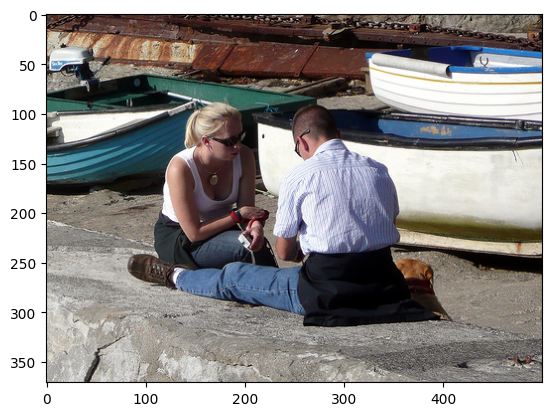

In [29]:
for i in range(5):
    max_length = 39

    with open("tokenizer.pkl","rb") as tk:
        tokenizer = pickle.load(tk)

    #model = load_model('models/model_9.h5')
    #xception_model = Xception(include_top=False, pooling="avg")
    photo = load_test("Dataset/Images/"+test[i])
    img = Image.open("Dataset/Images/"+test[i])
    description = generate_desc(model, tokenizer, photo, max_length)
    print("\n\n")
    print(description)
    plt.imshow(img)
    

In [1]:
test_img = r"Test_images/istockphoto-185158084-170667a.jpg"

max_length = 39

with open("tokenizer.pkl","rb") as tk:
    tokenizer = pickle.load(tk)

#model = load_model('models/model_9.h5')
#xception_model = Xception(include_top=False, pooling="avg")
photo = load_test(test_img)
img = Image.open(test_img)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

NameError: name 'pickle' is not defined

In [ ]:
np.array(features["1000268201_693b08cb0e.jpg"]).shape